<a href="https://colab.research.google.com/github/MingzheHu-Duke/CS534-Machine-Learning/blob/main/CS534_HW4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification of the Ionosphere Dataset

## Data Exploration

In [213]:
# Import the packages
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from tqdm.notebook import tqdm
from sklearn.tree import DecisionTreeClassifier

The data set can be found at: https://archive.ics.uci.edu/ml/machine-learning-databases/ionosphere/ionosphere.data

In [204]:
# Read in the data into data frame and view the first 10 rows
df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases\
/ionosphere/ionosphere.data", header=None)
# We should add the column names for easier operation
df.columns = list(range(35))
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34
0,1,0,0.99539,-0.05889,0.85243,0.02306,0.83398,-0.37708,1.00000,0.03760,0.85243,-0.17755,0.59755,-0.44945,0.60536,-0.38223,0.84356,-0.38542,0.58212,-0.32192,0.56971,-0.29674,0.36946,-0.47357,0.56811,-0.51171,0.41078,-0.46168,0.21266,-0.34090,0.42267,-0.54487,0.18641,-0.45300,g
1,1,0,1.00000,-0.18829,0.93035,-0.36156,-0.10868,-0.93597,1.00000,-0.04549,0.50874,-0.67743,0.34432,-0.69707,-0.51685,-0.97515,0.05499,-0.62237,0.33109,-1.00000,-0.13151,-0.45300,-0.18056,-0.35734,-0.20332,-0.26569,-0.20468,-0.18401,-0.19040,-0.11593,-0.16626,-0.06288,-0.13738,-0.02447,b
2,1,0,1.00000,-0.03365,1.00000,0.00485,1.00000,-0.12062,0.88965,0.01198,0.73082,0.05346,0.85443,0.00827,0.54591,0.00299,0.83775,-0.13644,0.75535,-0.08540,0.70887,-0.27502,0.43385,-0.12062,0.57528,-0.40220,0.58984,-0.22145,0.43100,-0.17365,0.60436,-0.24180,0.56045,-0.38238,g
3,1,0,1.00000,-0.45161,1.00000,1.00000,0.71216,-1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,-1.00000,0.14516,0.54094,-0.39330,-1.00000,-0.54467,-0.69975,1.00000,0.00000,0.00000,1.00000,0.90695,0.51613,1.00000,1.00000,-0.20099,0.25682,1.00000,-0.32382,1.00000,b
4,1,0,1.00000,-0.02401,0.94140,0.06531,0.92106,-0.23255,0.77152,-0.16399,0.52798,-0.20275,0.56409,-0.00712,0.34395,-0.27457,0.52940,-0.21780,0.45107,-0.17813,0.05982,-0.35575,0.02309,-0.52879,0.03286,-0.65158,0.13290,-0.53206,0.02431,-0.62197,-0.05707,-0.59573,-0.04608,-0.65697,g


In [205]:
num_col = len(df.columns)
num_row = len(df)
print("The Ionosphere dataset has {} feature columns,\
   {} rows.".format(num_col-1, num_row))
# Check the columns data types
# print(df.dtypes)

The Ionosphere dataset has 34 feature columns,   351 rows.


Attribute Information:

-- All 34 are continuous  
-- The 35th attribute is either "good" or "bad" according to the definition   summarized above. This is a binary classification task.

#### Preprocessing

**Class Distribution**

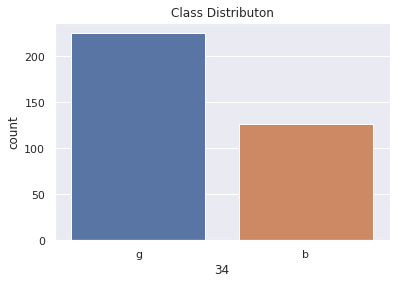

In [206]:
ax = sns.countplot(x=34, data=df)
ax.set_title("Class Distributon")
plt.show()

We can see that though this dataset has class imbalance problem, the problem is not severe.  
**Encoding the Output Class**

In [207]:
df.rename(columns={34: 'label'}, inplace=True)
df['label'] = df.label.astype('category')
encoding = {'g': 1, 'b': 0}
df.label.replace(encoding, inplace=True)

**Removing the useless features**

In [208]:
# Obeserve the variance of each feature
print(df.var()[0: -1])

0     0.096817
1     0.000000
2     0.247713
3     0.194865
4     0.270256
5     0.212346
6     0.242708
7     0.271180
8     0.257115
9     0.234112
10    0.317528
11    0.244844
12    0.387116
13    0.244899
14    0.426184
15    0.210104
16    0.381949
17    0.246772
18    0.392210
19    0.269440
20    0.371891
21    0.268496
22    0.364535
23    0.278210
24    0.334605
25    0.258567
26    0.266467
27    0.302528
28    0.331644
29    0.258038
30    0.326593
31    0.263759
32    0.273177
33    0.219340
dtype: float64


In [209]:
# As we can see that the second feature has no variance, and lets
# remove it
df.drop(columns=[1], inplace=True)

**Train Test Split**

In [210]:
X = df.values[:, :-1]
y = df.values[:, -1]
x_train, x_test, y_train, y_test = train_test_split(X, y,
                            test_size=0.2, random_state=2021)

**Standarization**

In [211]:
# Instantiate a scaler object
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

**Logistic Regression as the baseline model**

In [91]:
clf = LogisticRegression(random_state=2021).fit(x_train, y_train)
# Predict
y_pred = clf.predict(x_test)
# Evaluate
print("The classification accuracy of the baseline\
 model is: {:.3f}".format(accuracy_score(y_test, y_pred)))

The classification accuracy of the baseline model is: 0.915


#### Data Visualization

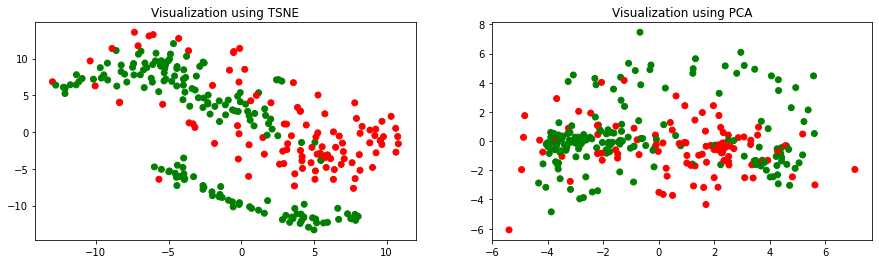

In [78]:
from sklearn.manifold import TSNE

# TSNE
x_embedded = TSNE(n_components=2).fit_transform(x_train)
fig, axs = plt.subplots(1, 2)
fig.set_figwidth(15)
axs[0].scatter(x_embedded[:, 0], x_embedded[:, 1], color=['green' if label
                    else 'red' for label in y_train])
axs[0].set_title("Visualization using TSNE")
# PCA
x_embedded2 = PCA(n_components=2).fit_transform(x_train)
axs[1].scatter(x_embedded2[:, 0], x_embedded2[:, 1], color=['green' if label
                    else 'red' for label in y_train])
axs[1].set_title("Visualization using PCA")
plt.show()

As we can see, wth proper transformation, the classes can be linearly seperated, we would expect a fair classification performance.

## Random Forest Classifier

### Part A  
**sklearn.ensemble.RandomForestClassifier**

#### 2.a.

In [157]:
# Choices of max features
m = [1, "sqrt", None]

# Conduct the cross validtion
cv = KFold(n_splits=5, shuffle=True, random_state=2021)

# The dict that store the data
accu_dict = dict()

# Iterate over the possible number of max features
for m_features in tqdm(m, desc="Max Features"):
  # Split the data
  temp_list = []
  for num_tree in tqdm(range(10, 200, 2), desc="Trees Number"):
    accu_list = []
    for train_ix, test_ix in cv.split(X):
      X_train, X_test = X[train_ix, :], X[test_ix, :]
      y_train, y_test = y[train_ix], y[test_ix]
      # Standarization
      scaler = StandardScaler()
      x_train = scaler.fit_transform(X_train)
      x_test = scaler.fit_transform(X_test)
      # The maximum number of split
      max_split = x_train.shape[0] - 1
      clf = RandomForestClassifier(max_features=m_features,
                    n_estimators = num_tree, 
                    max_leaf_nodes=max_split+1, 
                    random_state=2021).fit(X_train, y_train)
      y_pred = clf.predict(X_test)
      # Calculate the accuracy
      accu = accuracy_score(y_test, y_pred)
      accu_list.append(round(accu, 3))
      accu_mean = round(np.mean(accu_list), 3)
    temp_list.append(accu_mean)
  if m_features == 1:
    accu_dict["1"] = temp_list
  elif m_features == "sqrt":
    accu_dict["sqrt"] = temp_list
  else:
    accu_dict["p"] = temp_list

Max Features:   0%|          | 0/3 [00:00<?, ?it/s]

Trees Number:   0%|          | 0/95 [00:00<?, ?it/s]

Trees Number:   0%|          | 0/95 [00:00<?, ?it/s]

Trees Number:   0%|          | 0/95 [00:00<?, ?it/s]

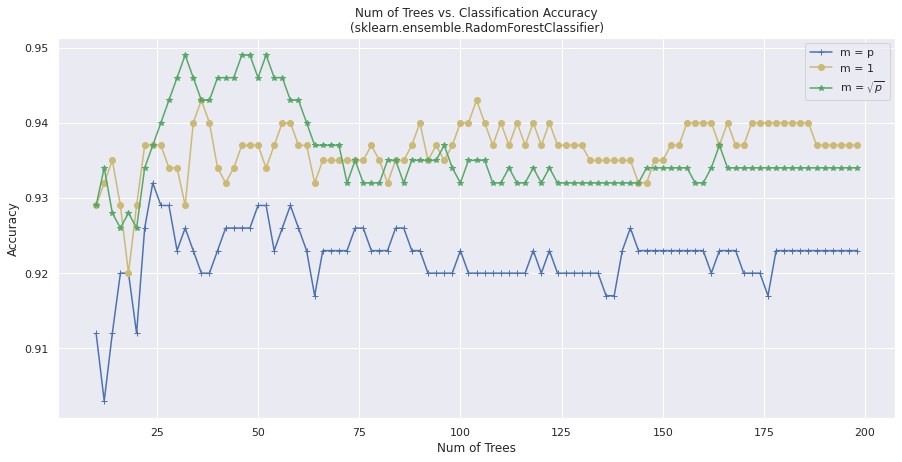

In [176]:
sns.set_theme()
plt.figure(figsize=(15, 7))
trees_axis = list(range(10, 200, 2))
plt.plot(trees_axis, accu_dict["p"], "b-+", label="m = p")
plt.plot(trees_axis, accu_dict["1"], "y-o", label="m = 1")
plt.plot(trees_axis, accu_dict["sqrt"], "g-*", label=r'm = $\sqrt{p}$')
plt.xlabel("Num of Trees")
plt.ylabel("Accuracy")
plt.title("Num of Trees vs. Classification Accuracy\
\n(sklearn.ensemble.RadomForestClassifier)")
plt.legend()
plt.show()

#### 2.b.

In [182]:
# Choices of min number of samples per terminal
nmin = [1, 10]

# Conduct the cross validtion
cv = KFold(n_splits=5, shuffle=True, random_state=2021)

# The dict that store the data
accu_dict = dict()

# Iterate over the possible number of nmin
for m in tqdm(nmin, desc="NMIN"):
  # Split the data
  temp_list = []
  for num_tree in tqdm(range(10, 200, 2), desc="Trees Number"):
    accu_list = []
    for train_ix, test_ix in cv.split(X):
      X_train, X_test = X[train_ix, :], X[test_ix, :]
      y_train, y_test = y[train_ix], y[test_ix]
      # Standarization
      scaler = StandardScaler()
      x_train = scaler.fit_transform(X_train)
      x_test = scaler.fit_transform(X_test)
      # The maximum number of split
      max_split = x_train.shape[0] - 1
      clf = RandomForestClassifier(max_features="sqrt",
                    n_estimators = num_tree,
                    min_samples_leaf = m, 
                    max_leaf_nodes=max_split+1, 
                    random_state=2021).fit(X_train, y_train)
      y_pred = clf.predict(X_test)
      # Calculate the accuracy
      accu = accuracy_score(y_test, y_pred)
      accu_list.append(round(accu, 3))
      accu_mean = round(np.mean(accu_list), 3)
    temp_list.append(accu_mean)
  if m == 1:
    accu_dict["1"] = temp_list
  else:
    accu_dict["10"] = temp_list

NMIN:   0%|          | 0/2 [00:00<?, ?it/s]

Trees Number:   0%|          | 0/95 [00:00<?, ?it/s]

Trees Number:   0%|          | 0/95 [00:00<?, ?it/s]

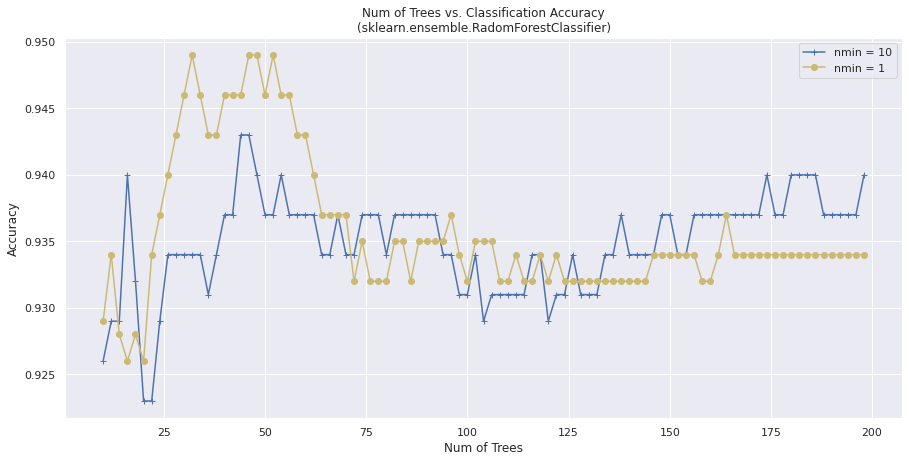

In [181]:
sns.set_theme()
plt.figure(figsize=(15, 7))
trees_axis = list(range(10, 200, 2))
plt.plot(trees_axis, accu_dict["10"], "b-+", label="nmin = 10")
plt.plot(trees_axis, accu_dict["1"], "y-o", label="nmin = 1")
plt.xlabel("Num of Trees")
plt.ylabel("Accuracy")
plt.title("Num of Trees vs. Classification Accuracy\
\n(sklearn.ensemble.RadomForestClassifier)")
plt.legend()
plt.show()

### Part B  
**Random Forest Classifier from scratch**

In [202]:
from random import seed, randrange
from csv import reader
from math import sqrt
# Convert string column to float
def str_column_to_flt(dataset, column):
    for row in dataset:
        row[column] = float( row[column].strip() )

# Convert string column to integer
def str_column_to_int(dataset, column):
    class_values = [ row[column] for row in dataset ]
    unique = set( class_values )
    lookup = dict()
    for i, value in enumerate( unique ): lookup[value] = i
    for row in dataset: row[column] = lookup[row[column]]
    return lookup

# Split a dataset into k folds 
def cross_validation_split(dataset, n_folds):
    dataset_split = list()
    dataset_copy = list(dataset)
    fold_size = len(dataset) / n_folds
    for i in xrange(n_folds):
        fold = list()
        while len(fold) < fold_size:
            index = randrange(len(dataset_copy))
            fold.append(dataset_copy.pop(index))
        dataset_split.append(fold)
    return dataset_split

# Calculate accuracy percentage 
def accuracy_metric(actual, predicted):
    correct = 0
    for i in xrange(len(actual)):
        if actual[i] == predicted[i]: correct += 1
    return 100. * correct / float( len(actual) )

# Evaluate an algorithm using a cross validation split
def evaluate_algorithm(dataset, algorithm, n_folds, *args):
    folds = cross_validation_split(dataset, n_folds)
    scores = list()
    for fold in folds:
        train_set = list(folds)
        train_set.remove(fold)
        train_set = sum(train_set, [])
        test_set = list()
        for row in fold:
            row_copy = list(row)
            test_set.append(row_copy)
            row_copy[-1] = None
        predicted = algorithm(train_set, test_set, *args)
        actual = [row[-1] for row in fold]
        accuracy = accuracy_metric(actual, predicted)
        scores.append(accuracy)
    return scores

# Split a dataset based on an attribute and an attribute value
def test_split(index, value, dataset):
    left, right = list(), list()
    for row in dataset:
        if row[index] < value: left.append(row)
        else: right.append(row)
    return left, right

# Calculate the Gini index for a split dataset
def gini_index(groups, class_values):
    gini = 0.0
    for class_value in class_values:
        for group in groups:
            size = len(group)
            if size == 0: continue
            proportion = [row[-1] for row in group].count(class_value) / float(size)
            gini += (proportion * (1.0 - proportion))
    return gini

# Select the best split point for a dataset
def get_split(dataset, n_features):
    class_values = list(set(row[-1] for row in dataset))
    b_index, b_value, b_score, b_groups = 999, 999, 999, None
    features = list()
    while len(features) < n_features:
        index = randrange(len(dataset[0])-1)
        if index not in features: features.append(index)
    for index in features:
        for row in dataset:
            groups = test_split(index, row[index], dataset)
            gini = gini_index(groups, class_values)
            if gini < b_score: 
                b_index, b_value, b_score, b_groups = index, row[index], gini, groups
    return {'index': b_index, 'value': b_value, 'groups': b_groups}

# Create a terminal node value
def to_terminal(group):
    outcomes = [row[-1] for row in group]
    return max(set(outcomes), key=outcomes.count)

# Create child splits for a node or make terminal
def split(node, max_depth, min_size, n_features, depth):
    left, right = node['groups']
    del(node['groups'])
    # check for a no split
    if not left or not right:
        node['left'] = node['right'] = to_terminal(left + right)
        return
    # check for max depth
    if depth >= max_depth:
        node['left'], node['right'] = to_terminal(left), to_terminal(right)
        return
    # process left child
    if len(left) <= min_size:
        node['left'] = to_terminal(left)
    else:
        node['left'] = get_split(left, n_features)
        split(node['left'], max_depth, min_size, n_features, depth+1)
    # process right child
    if len(right) <= min_size:
        node['right'] = to_terminal(right)
    else:
        node['right'] = get_split(right, n_features)
        split(node['right'], max_depth, min_size, n_features, depth+1)
 
# Build a decision tree
def build_tree(train, max_depth, min_size, n_features):
    root = get_split(dataset, n_features)
    split(root, max_depth, min_size, n_features, 1)
    return root
 
# Make a prediction with a decision tree
def predict(node, row):
    if row[node['index']] < node['value']:
        if isinstance(node['left'], dict): return predict(node['left'], row)
        else: return node['left']
    else:
        if isinstance(node['right'], dict): return predict(node['right'], row)
        else: return node['right']
 
# Create a random subsample from the dataset with replacement
def subsample(dataset, ratio):
    sample = list()
    n_sample = round(len(dataset) * ratio)
    while len(sample) < n_sample:
        index = randrange(len(dataset))
        sample.append(dataset[index])
    return sample
 
# Make a prediction with a list of bagged trees
def bagging_predict(trees, row):
    predictions = [predict(tree, row) for tree in trees]
    return max(set(predictions), key=predictions.count)
 
# Random Forest Algorithm
def random_forest(train, test, max_depth, min_size, sample_size, n_trees, n_features):
    trees = list()
    for i in range(n_trees):
        sample = subsample(train, sample_size)
        tree = build_tree(sample, max_depth, min_size, n_features)
        trees.append(tree)
    predictions = [bagging_predict(trees, row) for row in test]
    return(predictions)

In [195]:
X1 = X
y1 = y
# Choices of max features
m = [1, sqrt(p), p]

# Conduct the cross validtion
cv = KFold(n_splits=5, shuffle=True, random_state=2021)

# The dict that store the data
accu_dict = dict()

# Iterate over the possible number of max features
for m_features in tqdm(m, desc="Max Features"):
  # Split the data
  temp_list = []
  for num_tree in tqdm(range(10, 200, 2), desc="Trees Number"):
    accu_list = []
    for train_ix, test_ix in cv.split(X1):
      X_train, X_test = X1[train_ix, :], X1[test_ix, :]
      y_train, y_test = y1[train_ix], y1[test_ix]
      # Standarization
      scaler = StandardScaler()
      x_train = scaler.fit_transform(X_train)
      x_test = scaler.fit_transform(X_test)
      # The maximum number of split
      max_split = x_train.shape[0] - 1
      y_pred = random_forest(train=x_train,
                  test=x_test,
                  max_depth=10, 
                  min_size=1, 
                  sample_size=1, 
                  n_trees=num_tree, 
                  n_features=m_features)
      # Calculate the accuracy
      accu = accuracy_score(y_test, y_pred)
      accu_list.append(round(accu, 3))
      accu_mean = round(np.mean(accu_list), 3)
    temp_list.append(accu_mean)
  if m_features == 1:
    accu_dict["1"] = temp_list
  elif m_features == "sqrt":
    accu_dict["sqrt"] = temp_list
  else:
    accu_dict["p"] = temp_list

Max Features:   0%|          | 0/3 [00:00<?, ?it/s]

Trees Number:   0%|          | 0/95 [00:00<?, ?it/s]

Trees Number:   0%|          | 0/95 [00:00<?, ?it/s]

Trees Number:   0%|          | 0/95 [00:00<?, ?it/s]

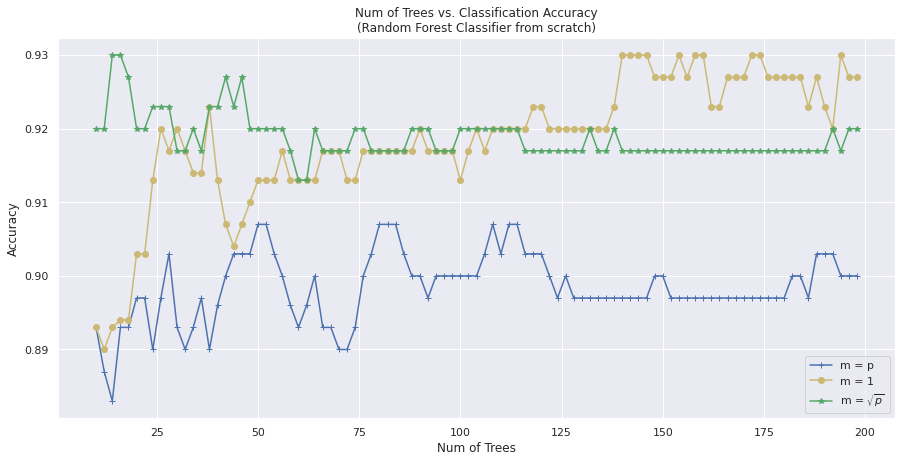

In [197]:
sns.set_theme()
plt.figure(figsize=(15, 7))
trees_axis = list(range(10, 200, 2))
plt.plot(trees_axis, accu_dict["p"], "b-+", label="m = p")
plt.plot(trees_axis, accu_dict["1"], "y-o", label="m = 1")
plt.plot(trees_axis, accu_dict["sqrt"], "g-*", label=r'm = $\sqrt{p}$')
plt.xlabel("Num of Trees")
plt.ylabel("Accuracy")
plt.title("Num of Trees vs. Classification Accuracy\
\n(Random Forest Classifier from scratch)")
plt.legend()
plt.show()

In [199]:
# Choices of min number of samples per terminal
nmin = [1, 10]

# Conduct the cross validtion
cv = KFold(n_splits=5, shuffle=True, random_state=2021)

# The dict that store the data
accu_dict = dict()

# Iterate over the possible number of nmin
for m in tqdm(nmin, desc="NMIN"):
  # Split the data
  temp_list = []
  for num_tree in tqdm(range(10, 200, 2), desc="Trees Number"):
    accu_list = []
    for train_ix, test_ix in cv.split(X1):
      X_train, X_test = X1[train_ix, :], X1[test_ix, :]
      y_train, y_test = y1[train_ix], y1[test_ix]
      # Standarization
      scaler = StandardScaler()
      x_train = scaler.fit_transform(X_train)
      x_test = scaler.fit_transform(X_test)
      # The maximum number of split
      max_split = x_train.shape[0] - 1
      y_pred = random_forest(train=x_train,
                  test=x_test,
                  max_depth=10, 
                  min_size=m, 
                  sample_size=1, 
                  n_trees=num_tree, 
                  n_features=sqrt(p)
      y_pred = clf.predict(X_test)
      # Calculate the accuracy
      accu = accuracy_score(y_test, y_pred)
      accu_list.append(round(accu, 3))
      accu_mean = round(np.mean(accu_list), 3)
    temp_list.append(accu_mean)
  if m == 1:
    accu_dict["1"] = temp_list
  else:
    accu_dict["10"] = temp_list

NMIN:   0%|          | 0/2 [00:00<?, ?it/s]

Trees Number:   0%|          | 0/95 [00:00<?, ?it/s]

Trees Number:   0%|          | 0/95 [00:00<?, ?it/s]

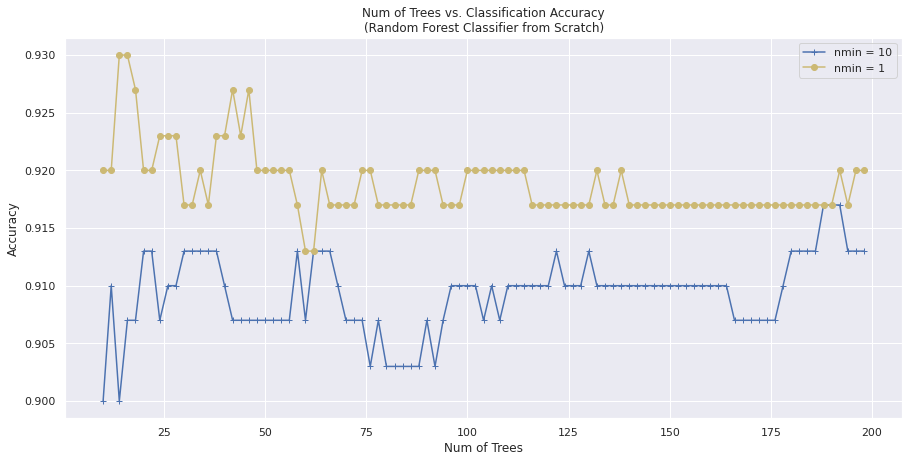

In [201]:
sns.set_theme()
plt.figure(figsize=(15, 7))
trees_axis = list(range(10, 200, 2))
plt.plot(trees_axis, accu_dict["10"], "b-+", label="nmin = 10")
plt.plot(trees_axis, accu_dict["1"], "y-o", label="nmin = 1")
plt.xlabel("Num of Trees")
plt.ylabel("Accuracy")
plt.title("Num of Trees vs. Classification Accuracy\
\n(Random Forest Classifier from Scratch)")
plt.legend()
plt.show()

## Adaboost M.1.

### Part A  
**sklearn.ensemble.AdaBoostClassifier**

#### 1.a.

In [217]:
# Stumps, 5-node trees or 10-node trees
m = [1, 5, 10]

# Conduct the cross validtion
cv = KFold(n_splits=5, shuffle=True, random_state=2021)

# The dict that store the data
accu_dict = dict()

# Iterate over the possible number of max features
for m_nodes in tqdm(m, desc="Max Nodes"):
  # Split the data
  temp_list = []
  for num_estimator in tqdm(range(10, 300, 3), desc="Learner Num"):
    accu_list = []
    for train_ix, test_ix in cv.split(X):
      X_train, X_test = X[train_ix, :], X[test_ix, :]
      y_train, y_test = y[train_ix], y[test_ix]
      # Standarization
      scaler = StandardScaler()
      x_train = scaler.fit_transform(X_train)
      x_test = scaler.fit_transform(X_test)
      # Adaboost
      clf = AdaBoostClassifier(base_estimator=
                  DecisionTreeClassifier(max_depth=m_nodes),
                  n_estimators=num_estimator).fit(X_train, y_train)
      y_pred = clf.predict(X_test)
      # Calculate the accuracy
      accu = accuracy_score(y_test, y_pred)
      accu_list.append(round(accu, 3))
      accu_mean = round(np.mean(accu_list), 3)
    temp_list.append(accu_mean)
  if m_nodes == 1:
    accu_dict["1"] = temp_list
  elif m_nodes == 5:
    accu_dict["5"] = temp_list
  else:
    accu_dict["10"] = temp_list

Max Nodes:   0%|          | 0/3 [00:00<?, ?it/s]

Learner Num:   0%|          | 0/97 [00:00<?, ?it/s]

Learner Num:   0%|          | 0/97 [00:00<?, ?it/s]

Learner Num:   0%|          | 0/97 [00:00<?, ?it/s]

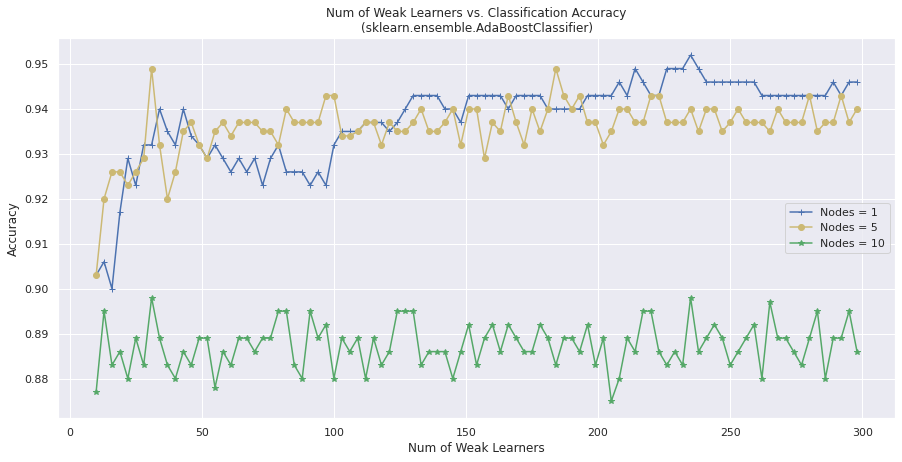

In [218]:
sns.set_theme()
plt.figure(figsize=(15, 7))
trees_axis = list(range(10, 300, 3))
plt.plot(trees_axis, accu_dict["1"], "b-+", label="Nodes = 1")
plt.plot(trees_axis, accu_dict["5"], "y-o", label="Nodes = 5")
plt.plot(trees_axis, accu_dict["10"], "g-*", label="Nodes = 10")
plt.xlabel("Num of Weak Learners")
plt.ylabel("Accuracy")
plt.title("Num of Weak Learners vs. Classification Accuracy\
\n(sklearn.ensemble.AdaBoostClassifier)")
plt.legend()
plt.show()

#### 1.b.

In [219]:
# Shrinkage or Ordinary Classifier
m = [1, 0.9]

# Conduct the cross validtion
cv = KFold(n_splits=5, shuffle=True, random_state=2021)

# The dict that store the data
accu_dict = dict()

# Iterate over the possible number of max features
for shrinkage_num in tqdm(m, desc="Shrinkage"):
  # Split the data
  temp_list = []
  for num_estimator in tqdm(range(10, 300, 3), desc="Learner Num"):
    accu_list = []
    for train_ix, test_ix in cv.split(X):
      X_train, X_test = X[train_ix, :], X[test_ix, :]
      y_train, y_test = y[train_ix], y[test_ix]
      # Standarization
      scaler = StandardScaler()
      x_train = scaler.fit_transform(X_train)
      x_test = scaler.fit_transform(X_test)
      # Adaboost
      clf = AdaBoostClassifier(base_estimator=
                  DecisionTreeClassifier(max_depth=5),
                  learning_rate = shrinkage_num,
                  n_estimators=num_estimator).fit(X_train, y_train)
      y_pred = clf.predict(X_test)
      # Calculate the accuracy
      accu = accuracy_score(y_test, y_pred)
      accu_list.append(round(accu, 3))
      accu_mean = round(np.mean(accu_list), 3)
    temp_list.append(accu_mean)
  if shrinkage_num == 1:
    accu_dict["ordinary"] = temp_list
  else:
    accu_dict["shrinked"] = temp_list

Shrinkage:   0%|          | 0/2 [00:00<?, ?it/s]

Learner Num:   0%|          | 0/97 [00:00<?, ?it/s]

Learner Num:   0%|          | 0/97 [00:00<?, ?it/s]

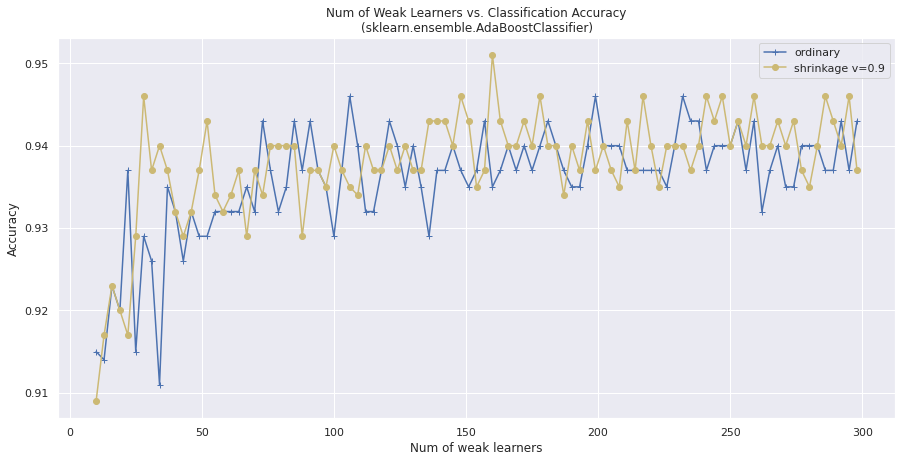

In [222]:
sns.set_theme()
plt.figure(figsize=(15, 7))
trees_axis = list(range(10, 300, 3))
plt.plot(trees_axis, accu_dict["ordinary"], "b-+", label="ordinary")
plt.plot(trees_axis, accu_dict["shrinked"], "y-o", label="shrinkage v=0.9")
plt.xlabel("Num of weak learners")
plt.ylabel("Accuracy")
plt.title("Num of Weak Learners vs. Classification Accuracy\
\n(sklearn.ensemble.AdaBoostClassifier)")
plt.legend()
plt.show()

### Part B  
**AdaBoost M.1 Classifier from scratch**

In [ ]:
def I(flag):
    return 1 if flag else 0

def sign(x):
    return abs(x)/x if x!=0 else 1       

class AdaBoost:
    
    def __init__(self,n_estimators=50, max_depth=5, learning_rate=1):
        self.n_estimators = n_estimators
        self.models = [None]*n_estimators
        self.max_depth = max_depth
        self.learning_rate = learning_rate 
        
    def fit(self,X,y):
        
        X = np.float64(X)
        N = len(y)
        w = np.array([1/N for i in range(N)])
        
        for m in range(self.n_estimators):
            
            Gm = DecisionTreeClassifier(max_depth=self.max_depth)\
                        .fit(X,y,sample_weight=w).predict
                        
            errM = sum([w[i]*I(y[i]!=Gm(X[i].reshape(1,-1))) \
                        for i in range(N)])/sum(w)
            
            AlphaM = self.learning_rate * np.log((1-errM)/errM)
            
            w = [w[i]*np.exp(AlphaM*I(y[i]!=Gm(X[i].reshape(1,-1))))\
                     for i in range(N)] 
            
            
            self.models[m] = (AlphaM,Gm)

    def predict(self,X):
        
        y = 0
        for m in range(self.n_estimators):
            AlphaM,Gm = self.models[m]
            y += AlphaM*Gm(X)
        signA = np.vectorize(sign)
        y = np.where(signA(y)==-1,-1,1)
        return y

In [224]:
X1 = X[:300, :]
y1 = y[:300]
# Stumps, 5-node trees or 10-node trees
m = [1, 5, 10]

# Conduct the cross validtion
cv = KFold(n_splits=5, shuffle=True, random_state=2021)

# The dict that store the data
accu_dict = dict()

# Iterate over the possible number of max features
for m_nodes in tqdm(m, desc="Max Nodes"):
  # Split the data
  temp_list = []
  for num_estimator in tqdm(range(10, 300, 3), desc="Learner Num"):
    accu_list = []
    for train_ix, test_ix in cv.split(X1):
      X_train, X_test = X1[train_ix, :], X1[test_ix, :]
      y_train, y_test = y1[train_ix], y1[test_ix]
      # Standarization
      scaler = StandardScaler()
      x_train = scaler.fit_transform(X_train)
      x_test = scaler.fit_transform(X_test)
      # Adaboost
      clf = AdaBoost(
                  max_depth=m_nodes,
                  n_estimators=num_estimator).fit(X_train, y_train)
      y_pred = clf.predict(X_test)
      # Calculate the accuracy
      accu = accuracy_score(y_test, y_pred)
      accu_list.append(round(accu, 3))
      accu_mean = round(np.mean(accu_list), 3)
    temp_list.append(accu_mean)
  if m_nodes == 1:
    accu_dict["1"] = temp_list
  elif m_nodes == 5:
    accu_dict["5"] = temp_list
  else:
    accu_dict["10"] = temp_list

Max Nodes:   0%|          | 0/3 [00:00<?, ?it/s]

Learner Num:   0%|          | 0/97 [00:00<?, ?it/s]

Learner Num:   0%|          | 0/97 [00:00<?, ?it/s]

Learner Num:   0%|          | 0/97 [00:00<?, ?it/s]

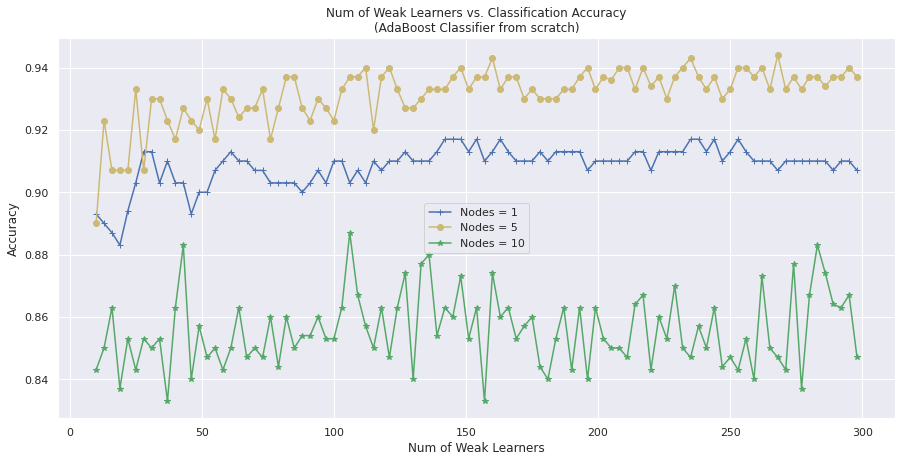

In [226]:
sns.set_theme()
plt.figure(figsize=(15, 7))
trees_axis = list(range(10, 300, 3))
plt.plot(trees_axis, accu_dict["1"], "b-+", label="Nodes = 1")
plt.plot(trees_axis, accu_dict["5"], "y-o", label="Nodes = 5")
plt.plot(trees_axis, accu_dict["10"], "g-*", label="Nodes = 10")
plt.xlabel("Num of Weak Learners")
plt.ylabel("Accuracy")
plt.title("Num of Weak Learners vs. Classification Accuracy\
\n(AdaBoost Classifier from scratch)")
plt.legend()
plt.show()

In [227]:
# Shrinkage or Ordinary Classifier
m = [1, 0.9]

# Conduct the cross validtion
cv = KFold(n_splits=5, shuffle=True, random_state=2021)

# The dict that store the data
accu_dict = dict()

# Iterate over the possible number of max features
for shrinkage_num in tqdm(m, desc="Shrinkage"):
  # Split the data
  temp_list = []
  for num_estimator in tqdm(range(10, 300, 3), desc="Learner Num"):
    accu_list = []
    for train_ix, test_ix in cv.split(X1):
      X_train, X_test = X1[train_ix, :], X1[test_ix, :]
      y_train, y_test = y1[train_ix], y1[test_ix]
      # Standarization
      scaler = StandardScaler()
      x_train = scaler.fit_transform(X_train)
      x_test = scaler.fit_transform(X_test)
      # Adaboost
      clf = AdaBoostClassifier(max_depth=5,
                  learning_rate = shrinkage_num,
                  n_estimators=num_estimator).fit(X_train, y_train)
      y_pred = clf.predict(X_test)
      # Calculate the accuracy
      accu = accuracy_score(y_test, y_pred)
      accu_list.append(round(accu, 3))
      accu_mean = round(np.mean(accu_list), 3)
    temp_list.append(accu_mean)
  if shrinkage_num == 1:
    accu_dict["ordinary"] = temp_list
  else:
    accu_dict["shrinked"] = temp_list

Shrinkage:   0%|          | 0/2 [00:00<?, ?it/s]

Learner Num:   0%|          | 0/97 [00:00<?, ?it/s]

Learner Num:   0%|          | 0/97 [00:00<?, ?it/s]

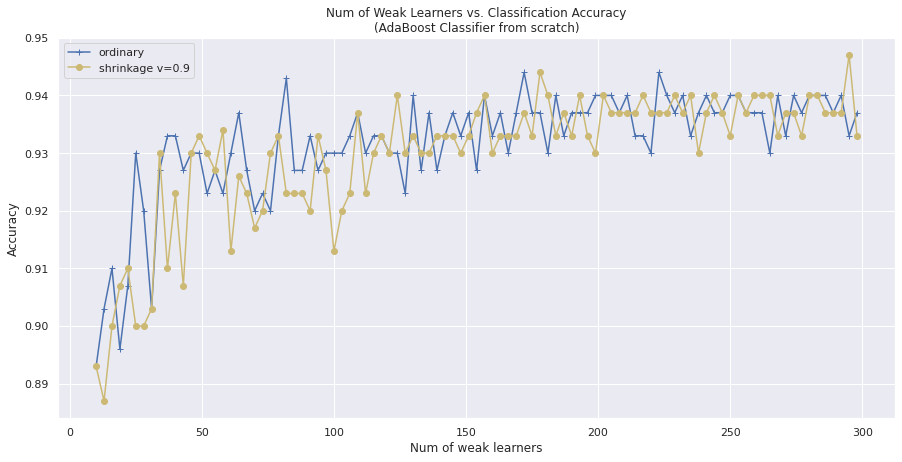

In [228]:
sns.set_theme()
plt.figure(figsize=(15, 7))
trees_axis = list(range(10, 300, 3))
plt.plot(trees_axis, accu_dict["ordinary"], "b-+", label="ordinary")
plt.plot(trees_axis, accu_dict["shrinked"], "y-o", label="shrinkage v=0.9")
plt.xlabel("Num of weak learners")
plt.ylabel("Accuracy")
plt.title("Num of Weak Learners vs. Classification Accuracy\
\n(AdaBoost Classifier from scratch)")
plt.legend()
plt.show()